In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.ensemble import RandomForestClassifier
# from cuml.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split


random_seed = 42
random.seed(random_seed)


source_folder = '/kaggle/input/microscopic-peripheral-blood-cell-images/PBC_dataset_normal_DIB'
for i in [0.01, 0.1, 0.5, 0.7]:
    train_ratio = i
    test_size = 4000   
    destination_folder = f'data {i}'
    os.makedirs(os.path.join(destination_folder, 'train'), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, 'val'), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, 'test'), exist_ok=True)

    total_images = []
    class_images = {}

    for class_name in os.listdir(source_folder):
        class_folder = os.path.join(source_folder, class_name)

        if os.path.isdir(class_folder):
            images = os.listdir(class_folder)
            total_images.extend([(class_name, img) for img in images])
            class_images[class_name] = images

    random.shuffle(total_images)

    train_count = max(1, int(len(total_images) * train_ratio))
    train_images = total_images[:train_count]
    remaining_images = total_images[train_count:]

    test_images = remaining_images[:test_size]
    val_images = remaining_images[test_size:]

    train_class_images = {class_name: [] for class_name in class_images.keys()}
    test_class_images = {class_name: [] for class_name in class_images.keys()}
    val_class_images = {class_name: [] for class_name in class_images.keys()}

    for class_name, img in train_images:
        train_class_images[class_name].append(img)

    for class_name, img in test_images:
        test_class_images[class_name].append(img)

    for class_name, img in val_images:
        val_class_images[class_name].append(img)

    for class_name, images in train_class_images.items():
        class_folder = os.path.join(source_folder, class_name)
        train_dest = os.path.join(destination_folder, 'train', class_name)
        os.makedirs(train_dest, exist_ok=True)
        for img in images:
            shutil.copy(os.path.join(class_folder, img), os.path.join(train_dest, img))

    for class_name, images in val_class_images.items():
        class_folder = os.path.join(source_folder, class_name)
        val_dest = os.path.join(destination_folder, 'val', class_name)
        os.makedirs(val_dest, exist_ok=True)
        for img in images:
            shutil.copy(os.path.join(class_folder, img), os.path.join(val_dest, img))

    for class_name, images in test_class_images.items():
        class_folder = os.path.join(source_folder, class_name)
        test_dest = os.path.join(destination_folder, 'test', class_name)
        os.makedirs(test_dest, exist_ok=True)
        for img in images:
            shutil.copy(os.path.join(class_folder, img), os.path.join(test_dest, img))

    print(f"Data successfully split into train {i*100}%, val, and test (4000 images) folders with seed", random_seed)

Data successfully split into train 1.0%, val, and test (4000 images) folders with seed 42
Data successfully split into train 10.0%, val, and test (4000 images) folders with seed 42
Data successfully split into train 50.0%, val, and test (4000 images) folders with seed 42
Data successfully split into train 70.0%, val, and test (4000 images) folders with seed 42


In [4]:
import os

def filter_invalid_files(directory):
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.startswith('.'):
                print(f"Removing invalid file: {file}")
                os.remove(os.path.join(subdir, file))

for i in [0.01, 0.1, 0.5, 0.7]:
    filter_invalid_files(f'/kaggle/working/data {i}/train')
    filter_invalid_files(f'/kaggle/working/data {i}/test')
    filter_invalid_files(f'/kaggle/working/data {i}/val')

Removing invalid file: .DS_169665.jpg
Removing invalid file: .DS_169665.jpg
Removing invalid file: .DS_169665.jpg
Removing invalid file: .DS_169665.jpg


In [5]:
generators  = {}
keys = ['1%', '10%', '50%', '70%']

for index, i in enumerate([0.01, 0.1, 0.5, 0.7]):
    train_dir = f'/kaggle/working/data {i}/train'
    val_dir = f'/kaggle/working/data {i}/val'
    test_dir = f'/kaggle/working/data {i}/test'

    img_height, img_width = 224, 224
    batch_size = 32


    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    generators[keys[index]] = [train_generator, val_generator, test_generator]

Found 170 images belonging to 8 classes.
Found 12922 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.
Found 1709 images belonging to 8 classes.
Found 11384 images belonging to 8 classes.
Found 3999 images belonging to 8 classes.
Found 8546 images belonging to 8 classes.
Found 4546 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.
Found 11965 images belonging to 8 classes.
Found 1128 images belonging to 8 classes.
Found 3999 images belonging to 8 classes.


In [6]:
generators

{'1%': [<keras.src.legacy.preprocessing.image.DirectoryIterator at 0x79eeb0555810>,
 '10%': [<keras.src.legacy.preprocessing.image.DirectoryIterator at 0x79eeb05558a0>,
 '50%': [<keras.src.legacy.preprocessing.image.DirectoryIterator at 0x79eeb0557370>,
 '70%': [<keras.src.legacy.preprocessing.image.DirectoryIterator at 0x79eeb05544f0>,
  <keras.src.legacy.preprocessing.image.DirectoryIterator at 0x79eeb0554d60>]}

In [7]:
from tensorflow.keras.applications import MobileNetV2

base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_mobilenet.layers:
    layer.trainable = True
    
for layer in base_model_mobilenet.layers[0:-11]:
    layer.trainable = False

def extract_features(generator, base_model):
    features = base_model.predict(generator)
    labels = generator.classes
    return features, labels

features = {}
labels = {}

for i in keys:
    train_features_mobilenet, train_labels = extract_features(generators[i][0], base_model_mobilenet)
    val_features_mobilenet, val_labels = extract_features(generators[i][1], base_model_mobilenet)
    test_features_mobilenet, test_labels = extract_features(generators[i][2], base_model_mobilenet)

    train_features_mobilenet = train_features_mobilenet.reshape(train_features_mobilenet.shape[0], -1)
    val_features_mobilenet = val_features_mobilenet.reshape(val_features_mobilenet.shape[0], -1)
    test_features_mobilenet = test_features_mobilenet.reshape(test_features_mobilenet.shape[0], -1)
    
    features[i] = [train_features_mobilenet, val_features_mobilenet,test_features_mobilenet]
    labels[i] = [train_labels, val_labels,test_labels]

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 956ms/step
404/404 ━━━━━━━━━━━━━━━━━━━━ 282s 698ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 880ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 806ms/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 253s 710ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 664ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 234s 872ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 692ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 691ms/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 304s 813ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 630ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 98s 786ms/step


In [8]:
for i in keys:
    print(i ," \t: \t", features[i][0].shape)

1%  	: 	 (170, 62720)
10%  	: 	 (1709, 62720)
50%  	: 	 (8546, 62720)
70%  	: 	 (11965, 62720)


In [9]:
models = {}
keys = ['1%', '10%', '50%']
for i in keys:
    knn = KNeighborsClassifier()
    rf = RandomForestClassifier(random_state=42)
    # svm = SVC()
    # xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

    # Set up Grid Search for hyperparameter tuning
    param_grid_knn = {'n_neighbors': [3, 5, 7]}
    param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
    # param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    # param_grid_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}

    grid_knn = GridSearchCV(knn, param_grid_knn, cv=5)
    grid_rf = GridSearchCV(rf, param_grid_rf, cv=5)
    # grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)
    # grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5)
    grid_rf.fit(features[i][0], labels[i][0])
    print("rf done")
    grid_knn.fit(features[i][0], labels[i][0])
    print("knn done")
#     grid_svm.fit(features[i][0], labels[i][0])
#     print("svm done")
    print(f"Model fit successful on {i} data")
#     models[i] = [grid_rf, grid_knn, grid_svm]
    models[i] = [grid_rf, grid_knn]

rf done
knn done
Model fit successful on 1% data
rf done
knn done
Model fit successful on 10% data
rf done
knn done
Model fit successful on 50% data


In [10]:
# Evaluate on validation set
preds = {}
for i in keys:
    rf_test_pred_mobilenet = models[i][0].predict(features[i][2])
    knn_test_pred_mobilenet = models[i][1].predict(features[i][2])
#     svm_val_pred_mobilenet = grid_svm.predict(val_features_mobilenet)
#     preds[i] = [rf_val_pred_mobilenet, knn_val_pred_mobilenet, svm_val_pred_mobilenet]
    print(f"done in {i}")
    preds[i] = [rf_test_pred_mobilenet, knn_test_pred_mobilenet]

done in 1%
done in 10%
done in 50%


In [11]:
rf_test_pred_mobilenet == labels['50%'][2]

array([False, False, False, ..., False, False, False])

In [12]:
for i in keys:
    print("----------------------------------------------------------")
    print(f"MobileNetV2-RandomForest Test Accuracy on {i} data:", accuracy_score(labels[i][2], preds[i][0])*100)
    print(f"MobileNetV2-KNN Test Accuracy on {i} data:", accuracy_score(labels[i][2], preds[i][1])*100)
#     print(f"MobileNetV2-SVM Validation Accuracy on {i} data:", accuracy_score(labels[i][1], preds[i][2]))
    print("----------------------------------------------------------")

# # Compare size of ResNet50 and MobileNetV2
# resnet50_model_size = base_model.count_params()
# mobilenet_model_size = base_model_mobilenet.count_params()

# print(f"ResNet50 Model Size: {resnet50_model_size} parameters")
# print(f"MobileNetV2 Model Size: {mobilenet_model_size} parameters")

----------------------------------------------------------
MobileNetV2-RandomForest Test Accuracy on 1% data: 18.5
MobileNetV2-KNN Test Accuracy on 1% data: 17.325
----------------------------------------------------------
----------------------------------------------------------
MobileNetV2-RandomForest Test Accuracy on 10% data: 17.62940735183796
MobileNetV2-KNN Test Accuracy on 10% data: 15.153788447111777
----------------------------------------------------------
----------------------------------------------------------
MobileNetV2-RandomForest Test Accuracy on 50% data: 19.85
MobileNetV2-KNN Test Accuracy on 50% data: 15.725
----------------------------------------------------------


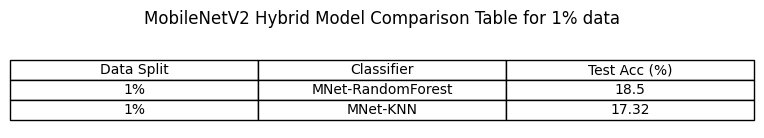

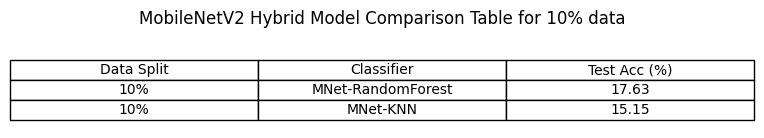

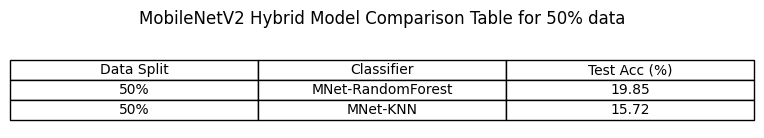

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

for i in keys:
    data = {
        'Data Split': [f'{i}', f'{i}'],
#         'Classifier': ['MNet-RandomForest', 'MNet-KNN', 'MNet-SVM'],
        'Classifier': ['MNet-RandomForest', 'MNet-KNN'],
        'Test Acc (%)': [round(accuracy_score(labels[i][2], preds[i][0])*100, 2),
                         round(accuracy_score(labels[i][2], preds[i][1])*100, 2)]
    }
#                          round(accuracy_score(labels[i][1], preds[i][2])*100, 2)]

    df = pd.DataFrame(data)
    fig, ax = plt.subplots(figsize=(8, 1))
    ax.axis('tight')
    ax.axis('off')
    tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2) 
    plt.title(f'MobileNetV2 Hybrid Model Comparison Table for {i} data', pad=20)
    plt.show()

In [14]:
mobilenet_model_size = base_model_mobilenet.count_params()
print(f"MobileNetV2 Model Size: {mobilenet_model_size} parameters")

MobileNetV2 Model Size: 2257984 parameters
